In [1]:
import sys
import logging
import importlib
import itertools
from pathlib import Path

import numpy as np  # type: ignore
from matplotlib import pyplot as plt  # type: ignore

sys.path.append('../../src/')
import utils.figures  # type: ignore # noqa: E402

In [2]:
data_dir = Path('../../data/')

In [3]:
importlib.reload(utils.figures)
from utils.figures import load_all_eliminateds_dict  # noqa: E402
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, force=True)
eliminateds = load_all_eliminateds_dict(data_dir)
logging.basicConfig(level=logging.WARNING, stream=sys.stderr, force=True)

DEBUG:root:Loading positive-mask from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading negative-mask from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading positive-mask from ../../data/benchmark_results/all-full-flat-spencer-cn.jsonl
DEBUG:root:Loading negative-mask from ../../data/benchmark_results/all-full-flat-spencer-cn.jsonl
DEBUG:root:Loading positive-mask from ../../data/benchmark_results/all-full-flat-spencer-in.jsonl
DEBUG:root:Loading negative-mask from ../../data/benchmark_results/all-full-flat-spencer-in.jsonl


In [4]:
importlib.reload(utils.figures)
from utils.figures import load_memo_sizes_dict  # noqa: E402
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, force=True)
memo_sizes = load_memo_sizes_dict(data_dir)
logging.basicConfig(level=logging.WARNING, stream=sys.stderr, force=True)

DEBUG:root:Loading positive-memo_entry from ../../data/benchmark_results/all-full-thompson-spencer-none.jsonl
DEBUG:root:Loading negative-memo_entry from ../../data/benchmark_results/all-full-thompson-spencer-none.jsonl
DEBUG:root:Loading positive-memo_entry from ../../data/benchmark_results/all-full-thompson-spencer-cn.jsonl
DEBUG:root:Loading negative-memo_entry from ../../data/benchmark_results/all-full-thompson-spencer-cn.jsonl
DEBUG:root:Loading positive-memo_entry from ../../data/benchmark_results/all-full-thompson-spencer-in.jsonl
DEBUG:root:Loading negative-memo_entry from ../../data/benchmark_results/all-full-thompson-spencer-in.jsonl
DEBUG:root:Loading positive-memo_entry from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading negative-memo_entry from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading positive-memo_entry from ../../data/benchmark_results/all-full-flat-spencer-cn.jsonl
DEBUG:root:Loading negative-memo

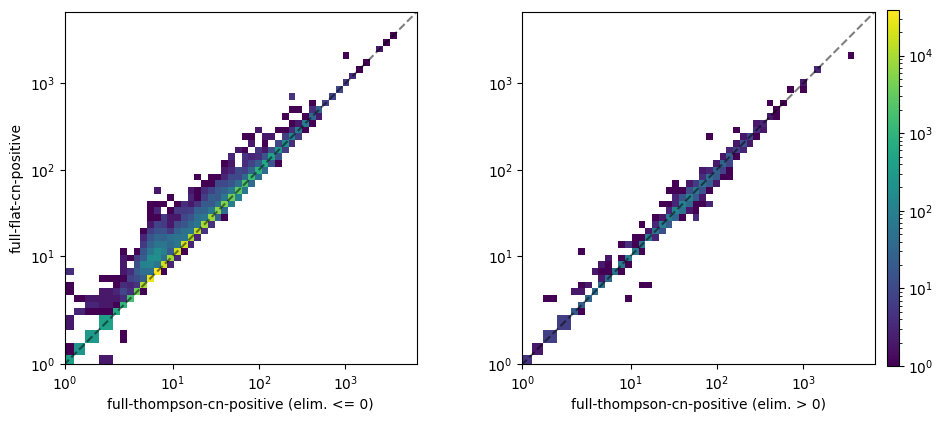

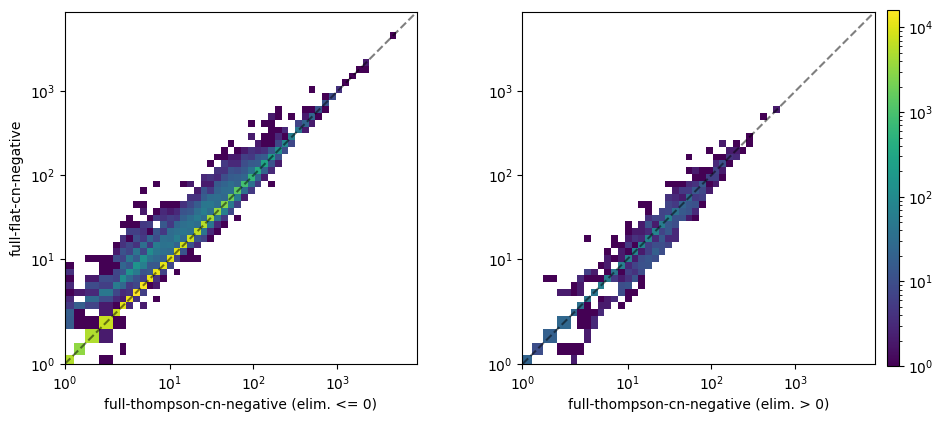

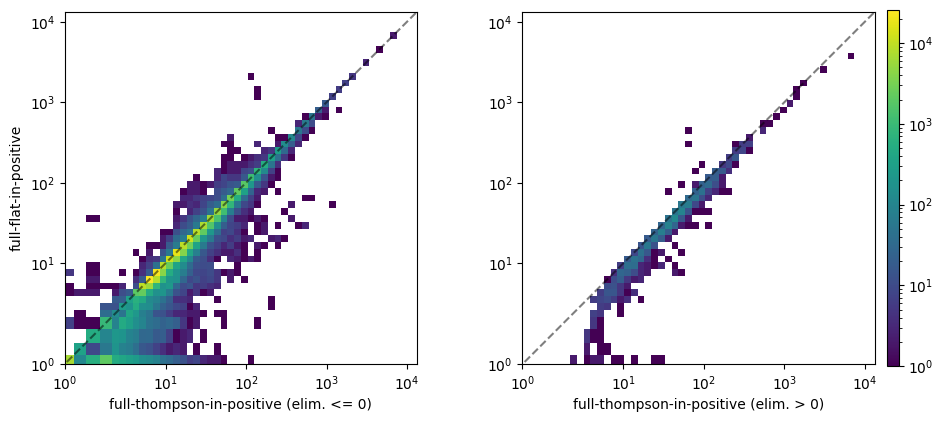

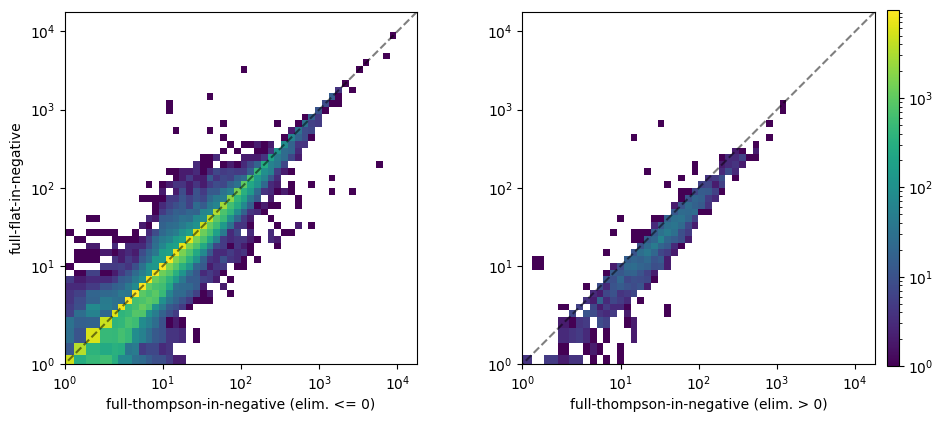

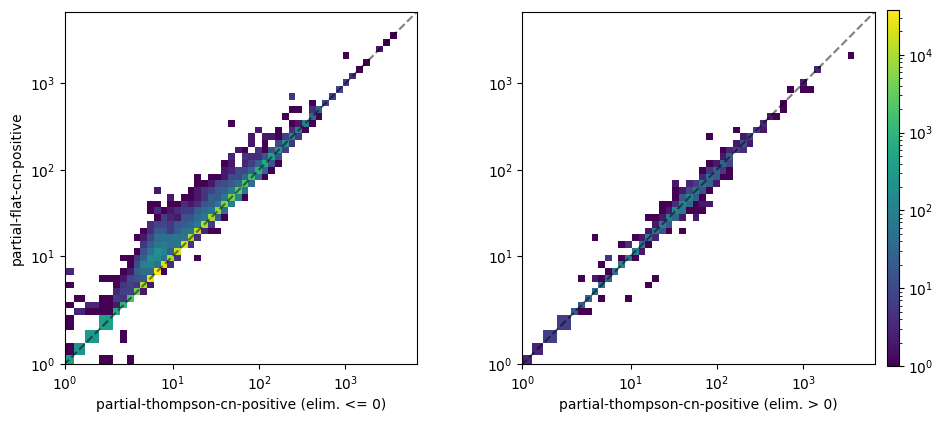

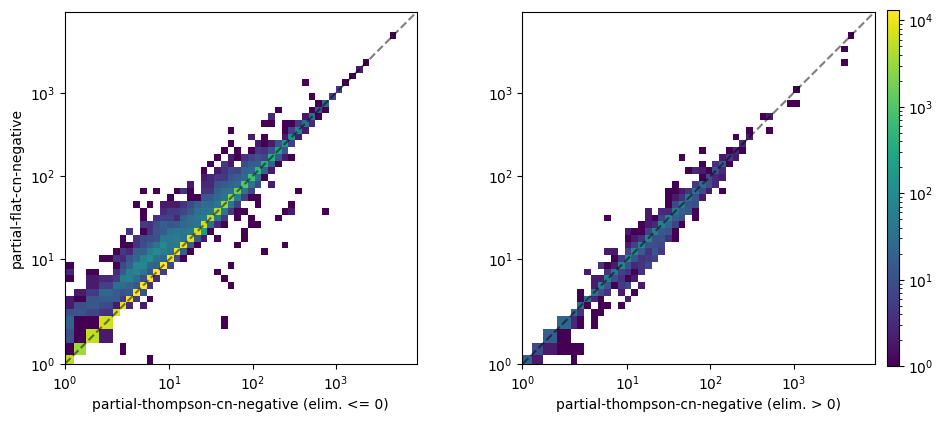

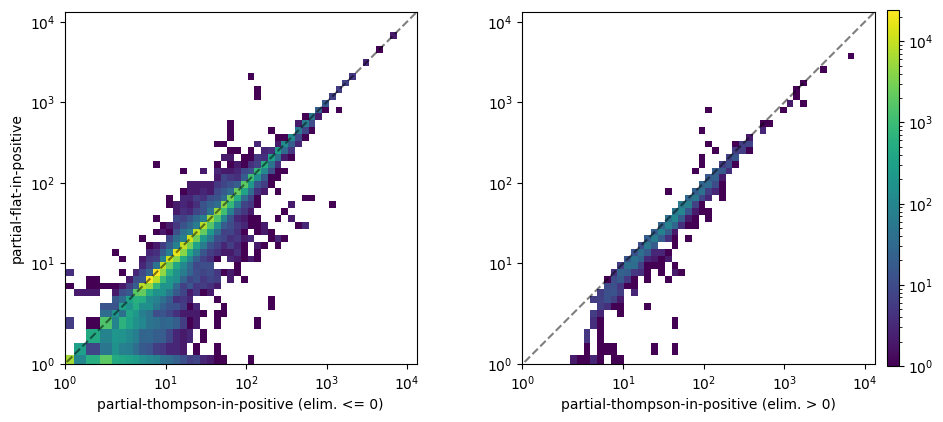

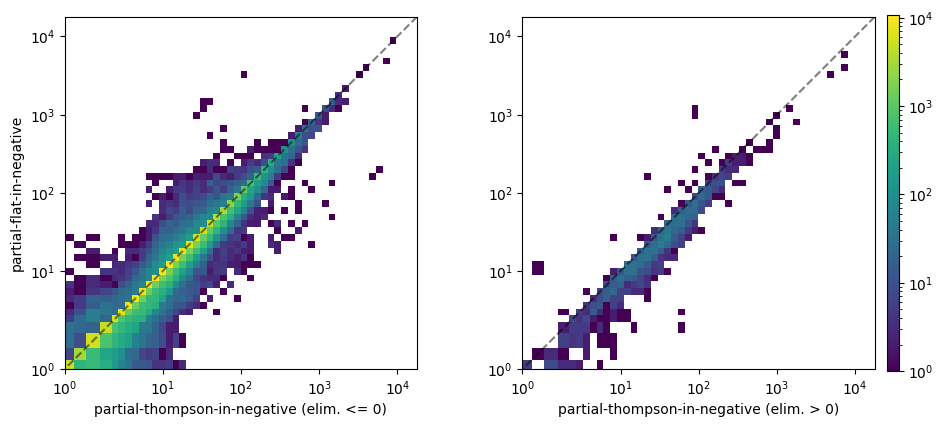

In [5]:
# Histogram 2D
importlib.reload(plt)

logging.basicConfig(level=logging.WARNING, stream=sys.stderr, force=True)
input_types = ['positive', 'negative']
options = itertools.product(['full', 'partial'], ['cn', 'in'], input_types)
threshold = 0

for matching_type, memo_scheme, input_type in options:
    xs = memo_sizes[matching_type]['thompson'][memo_scheme][input_type]
    ys = memo_sizes[matching_type]['flat'][memo_scheme][input_type]
    zs = eliminateds[memo_scheme][input_type]
    xlabel = "-".join([matching_type, 'thompson', memo_scheme, input_type])
    ylabel = "-".join([matching_type, 'flat', memo_scheme, input_type])
    filename = "-".join([matching_type, memo_scheme, input_type]) + '.pdf'

    # Range excluding outliers
    total = xs + ys
    quartile_1 = np.quantile(total, 0.25)
    quartile_3 = np.quantile(total, 0.75)
    iqr = quartile_3 - quartile_1
    maximum = np.max(
        total, where=xs <= quartile_3 + 1.5 * iqr, initial=-np.inf)
    minimum = np.min(total, where=xs >= quartile_1 - 1.5 * iqr, initial=np.inf)
    x_space = np.geomspace(1, max(xs+ys), 50)
    y_space = np.geomspace(1, max(ys+ys), 50)

    _h1, _, _ = np.histogram2d(
        xs[zs <= threshold], ys[zs <= threshold], bins=(x_space, y_space))
    _h2, _, _ = np.histogram2d(
        xs[zs > threshold], ys[zs > threshold], bins=(x_space, y_space))
    vmax = max(np.max(_h1), np.max(_h2))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    h, _, _, cmap = axes[0].hist2d(
        xs[zs <= threshold], ys[zs <= threshold],
        bins=(x_space, y_space), norm='log', vmin=1, vmax=vmax
    )
    axes[0].set_xscale('symlog')
    axes[0].set_yscale('symlog')
    axes[0].set_xlabel(xlabel + f" (elim. <= {threshold})")
    axes[0].set_ylabel(ylabel)
    axes[0].axis('square')

    axes[1].hist2d(xs[zs > threshold], ys[zs > threshold], bins=(
        x_space, y_space), norm='log', vmin=1, vmax=vmax)
    axes[1].set_xscale('symlog')
    axes[1].set_yscale('symlog')
    axes[1].set_xlabel(xlabel + f" (elim. > {threshold})")
    axes[1].axis('square')

    axes[0].plot([0, max(xs+ys)*2], [0, max(xs+ys)*2], alpha=0.5, color='black', linestyle='--')
    axes[1].plot([0, max(xs+ys)*2], [0, max(xs+ys)*2], alpha=0.5, color='black', linestyle='--')
    
    fig.subplots_adjust(right=0.8)
    axes[1].get_position()
    pos = axes[1].get_position()
    cbar_ax = fig.add_axes(
        [pos.x1 + 0.01, pos.y0 + 0.01, 0.01, pos.y1 - pos.y0 - 0.02])

    try:
        fig.colorbar(cmap, cax=cbar_ax)
        plt.subplots_adjust(wspace=0.3)
        output_dir = Path('./outputs/memo_sizes')
        output_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_dir / filename)
        plt.show()
    except Exception:
        continue